# Predicting Brand Exposure

## 01_Analysis and Visualization
* Prepare and structure data for analysis.
* This step is intended for data exploration to see if we can find patterns and insights

## Import and Load Data

In [1]:
#import libraries
import pandas as pd
import json
import geopandas as gpd
import pysal as ps
from pysal.contrib.viz import mapping as maps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#load data
excel_file_path = '../data_archives/df.xlsx'
json_file_path = '../data_archives/local_venue_poptimes.json'
shapefile_path = '../resources/Hydrography_Polygon.shp'
building_shapefile_path = '../resources/boston_buildings.shp'

df_raw = pd.read_excel(excel_file_path)   #dataframe of basic location information
json_data = open(json_file_path).read()   #json data that includes populartimes data
populartimes = json.loads(json_data)         #json data that includes populartimes data
shapefile = gpd.read_file(shapefile_path) #shapefile of boston waterway
building_shapefile = gpd.read_file(building_shapefile_path)

/Applications/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


## Preprocess and Structure Data

In [2]:
#drop duplicate values
df_raw = df_raw.drop_duplicates(keep='first',subset=['google_id', 'name','WeekTotals']).reset_index()

In [3]:
#Define type map for dimensionality reduction of venue type
type_maps = {'finance':['accounting','finance','atm','bank'],
             'retail':['store','clothing_store','jewelry_store','electronics_store','shoe_store','book_store','home_goods_store','furniture_store','hardware_store','pet_store','department_store','shopping_mall'],
             'transportation':['airport','bus_station','transit_station','gas_station','parking','car_rental','train_station','subway_station','light_rail_station'],
             'food':['cafe','bakery','meal_takeaway','restaurant','food','convenience_store','meal_delivery'],
             'bar':['bar','night_club','liquor_store'],
             'grocery':['grocery_or_supermarket','supermarket'],
             'health_wellness':['health','beauty_salon','hair_care','spa','gym','dentist','doctor','hospital','pharmacy','physiotherapist'],
             'automotive':['car_repair'],
             'professional_services':['lawyer','insurance_agency','general_contractor','travel_agency','real_estate_agency','veterinary_care'],
             'culture_entertainment':['art_gallery','library','museum','movie_theater','park','natural_feature','bowling_alley'],
             'religous':['church','place_of_worship','mosque','synagogue'],
             'government':['courthouse','local_government_office','fire_station','police','post_office'],
             'education':['school','university'],
             'lodging':['lodging'],
             'other':['point_of_interest','establishment','moving_company','storage','premise','bicycle_store','florist','cemetery','laundry','painter','locksmith','plumber','roofing_contractor','car_dealer','car_wash','electrician']}

In [4]:
#Convert venue type, which is currently a string, 
#to a list of words for each record
from keras.preprocessing.text import text_to_word_sequence

df_processed = df_raw.copy(deep=True)

for i in range(len(df_raw)):
    a = text_to_word_sequence(df_raw.iloc[i]['venue_type'], 
                              filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~', 
                              lower=False, 
                              split=' ')
    b = []
    for word in a:  
        c = text_to_word_sequence(word, 
                                  filters="'", 
                                  lower=False, 
                                  split=' ')
        b.append(c[0])
    df_processed.at[i,'venue_type'] = b
df_processed.head(1)

Using TensorFlow backend.


index                      name        lat       long  \
0      0  McMahon & Associates, PC  42.352366 -71.056066   

                     google_id  \
0  ChIJddqFA4Jw44kRHz6p3qWTs4c   

                                          venue_type  Monday  Tuesday  \
0  [accounting, lawyer, finance, point_of_interes...       0        0   

   Wednesday  Thursday  Friday  Saturday  Sunday  WeekTotals  
0          0         0       0         0       0           0

In [5]:
#map venue_type to one value based on type_map dictionary
type_list = []
for i in range(len(df_processed)):
    vals_to_map = df_processed.iloc[i]['venue_type']    
    for item in vals_to_map:
        for key in list(type_maps.keys()):            
            list_to_check = type_maps[key]            
            if item in list_to_check:
                type_list.append(key)
                break
        if item in list_to_check:
            break
df_processed['mapped_venue_type'] = pd.DataFrame({'type':type_list})
print(len(type_list))
df_processed.to_excel('../data_archives/df_processed.xlsx')
df_processed.head()

1723


index                        name        lat       long  \
0      0    McMahon & Associates, PC  42.352366 -71.056066   
1      1          Barclay Damon, LLP  42.352321 -71.056248   
2      2  Request Health Corporation  42.351584 -71.056269   
3      3                     StackUp  42.351586 -71.056323   
4      4                        KPMG  42.351781 -71.056737   

                     google_id  \
0  ChIJddqFA4Jw44kRHz6p3qWTs4c   
1  ChIJD75e1YBw44kRvDZoMEj44jY   
2  ChIJv1J9rnh644kR4hc29XVaEFg   
3  ChIJY_v-pXh744kRub1hj4RNwkk   
4  ChIJDaRRe4Jw44kRjXWBXIsFgj0   

                                          venue_type  Monday  Tuesday  \
0  [accounting, lawyer, finance, point_of_interes...       0        0   
1  [accounting, lawyer, finance, point_of_interes...       0        0   
2  [accounting, finance, point_of_interest, estab...       0        0   
3  [accounting, finance, point_of_interest, estab...       0        0   
4  [accounting, finance, point_of_interest, estab...       0        0   

   Wednesday  Thursday  Friday  Saturday  Sunday  WeekTotals mapped_venue_type  
0          0         0       0         0       0           0           finance  
1          0         0       0         0       0           0           finance  
2          0         0       0         0       0           0           finance  
3          0         0       0         0       0           0           finance  
4          0         0       0         0       0           0           finance

In [6]:
#build dataframe that expands records for every hour of activity during the day
#initialize empty lists
records_lat = []
records_lng = []
records_count = []
records_hour = []
records_day = []
records_google_id = []
records_name = []
#loop through each hour of each day for every venue and store lat, long, count, and hour into a dataframe
for day in range(6):
    for hour in range(24):
        for venue in range(len(populartimes)):
            venue_lat = populartimes[venue]['coordinates']['lat']
            venue_lng = populartimes[venue]['coordinates']['lng']
            count = populartimes[venue]['populartimes'][day]['data'][hour]
            hour_of_day = hour
            day_of_week = day
            google_id = populartimes[venue]['id']
            name = populartimes[venue]['name']
            
            #append data to list
            records_lat.append(venue_lat)
            records_lng.append(venue_lng)
            records_count.append(count)
            records_hour.append(hour_of_day)
            records_day.append(day_of_week)
            records_google_id.append(google_id)
            records_name.append(name)

#save lists to dataframe            
df_time_records = pd.DataFrame({"lat":records_lat,
                                "long":records_lng,
                                "count":records_count,
                                "hour":records_hour,
                                "day":records_day,
                                "google_id":records_google_id,
                                "name":records_name})
df_time_records.head()

lat       long  count  hour  day                    google_id  \
0  42.354131 -71.055962      0     0    0  ChIJKbYEhIRw44kRbesrXs_-t2c   
1  42.374258 -71.024628     55     0    0  ChIJmd9BFjhw44kRHqSMe4nZ2a4   
2  42.374899 -71.023227     14     0    0  ChIJnfWx5Ddw44kRKctc5RWyWLg   
3  42.354096 -71.055859      0     0    0  ChIJxbFHKoJw44kRLD7DEazE35I   
4  42.353683 -71.056617      0     0    0  ChIJE-NvPIJw44kRlflS-oyK0AQ   

                                                name  
0                                     Edelstein & Co  
1  JetBlue Airways (Maintenance-Materials) Hangar...  
2  Signature Flight Support BOS - Boston Logan In...  
3                                First Republic Bank  
4                           Boston Common Coffee Co.

In [7]:
#join dataframe with venue type
df_to_join = df_processed[['google_id','mapped_venue_type']]
df_time_records_joined = df_time_records.join(df_to_join.set_index('google_id'),on='google_id')
df_time_records_joined = df_time_records_joined.drop_duplicates(keep='first',subset=['hour', 'day','google_id'])

In [8]:
from sklearn.preprocessing import MinMaxScaler
#intialize new columns
df_time_records_joined['hour_transformed'] = 0
df_time_records_joined['day_transformed'] = 0
#initialize scaler object
scaler = MinMaxScaler()
#transform hour and day
scaler.fit(df_time_records_joined[['hour','day']])
df_time_records_joined[['hour_transformed','day_transformed']] = scaler.transform(df_time_records_joined[['hour','day']])
#format day_hour column
df_time_records_joined['day_hour'] = df_time_records_joined['day']+df_time_records_joined['hour_transformed']
df_time_records_joined.head(2)

lat       long  count  hour  day                    google_id  \
0  42.354131 -71.055962      0     0    0  ChIJKbYEhIRw44kRbesrXs_-t2c   
1  42.374258 -71.024628     55     0    0  ChIJmd9BFjhw44kRHqSMe4nZ2a4   

                                                name mapped_venue_type  \
0                                     Edelstein & Co           finance   
1  JetBlue Airways (Maintenance-Materials) Hangar...    transportation   

   hour_transformed  day_transformed  day_hour  
0               0.0              0.0       0.0  
1               0.0              0.0       0.0

In [9]:
#prepare data for kde by building a list of records 
#for each user count at each location
kde_x = []
kde_y = []

for i in range(len(df_raw)):
    lat = df_raw.iloc[i]['lat']
    lng = df_raw.iloc[i]['long']
    count = df_raw.iloc[i]['WeekTotals']
    if count > 0:
        for j in range(count):
            kde_x.append(lat)
            kde_y.append(lng)

## Visualize Data

In [10]:
#Prepare Plot Parameters
#define plot ranges
x_min = -71.07
y_min = 42.3425
x_max = -71.05
y_max = 42.356

#figure size
plot_size = (12,11)

### plot kde

<Figure size 864x792 with 0 Axes>

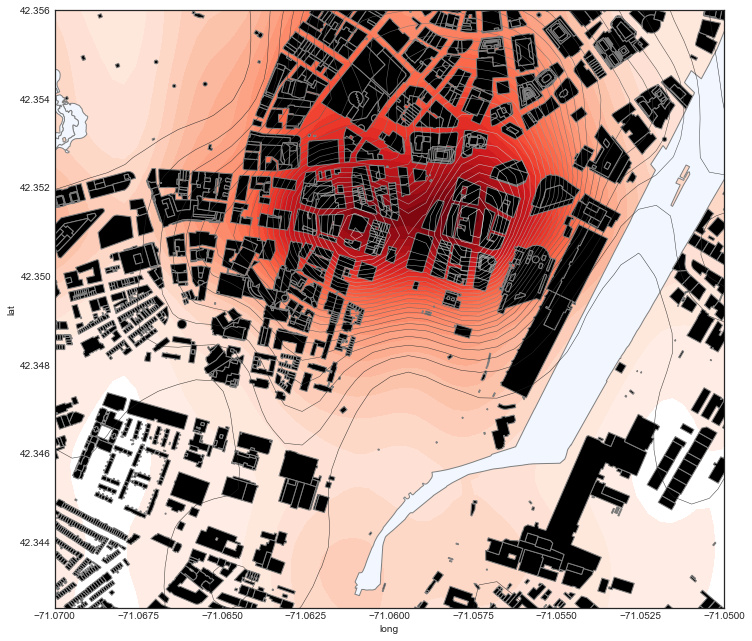

In [11]:
plt.figure(figsize=plot_size,facecolor='white')
plt.style.use('seaborn-white')

#define sample size
sample_size=10000

#sample data
X_sample = np.random.choice(kde_x,size=sample_size,replace=False)
y_sample = np.random.choice(kde_y,size=sample_size,replace=False)

#configure shapefile projection
building_shapefile = building_shapefile.to_crs({'init': 'epsg:4326'}) 

#define plot size
f, ax = plt.subplots(1, figsize=plot_size)

#define plot ranges
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

#plot kde of user density
ax = sns.kdeplot(y_sample, X_sample, 
                 shade=True,
                 cmap="Reds",
                 shade_lowest=False,
                 n_levels=30,
                 bw=.001,
                 gridsize=300)

#plot shapefile of boston buildings
ax = building_shapefile.plot(ax=ax,alpha=1.0,edgecolor='grey',facecolor='#000000')

#plot kde of  store density
ax = sns.kdeplot(df_processed['long'], df_processed['lat'],
                 shade=False,alpha=0.9,
                 shade_lowest=False,
                 n_levels=30,
                 linewidths=0.5,
                 bw=.001,
                 gridsize=300,
                 color="white")

#ax = sns.scatterplot(x='long',y='lat',data=df_processed,alpha=0.2)
#plot shapefile of boston waterway
ax = shapefile.plot(ax=ax,alpha=1,edgecolor='grey',facecolor='#f2f7ff')


#save to file
'''plt.savefig("../data_archives/plot_exports/kde/sample_{}.jpg".format(sample_size), dpi=300, edgecolor='w',
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None)'''
#show plot
plt.show()

## box and whisker for each venue type

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1859: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1860: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']


<Figure size 864x792 with 0 Axes>

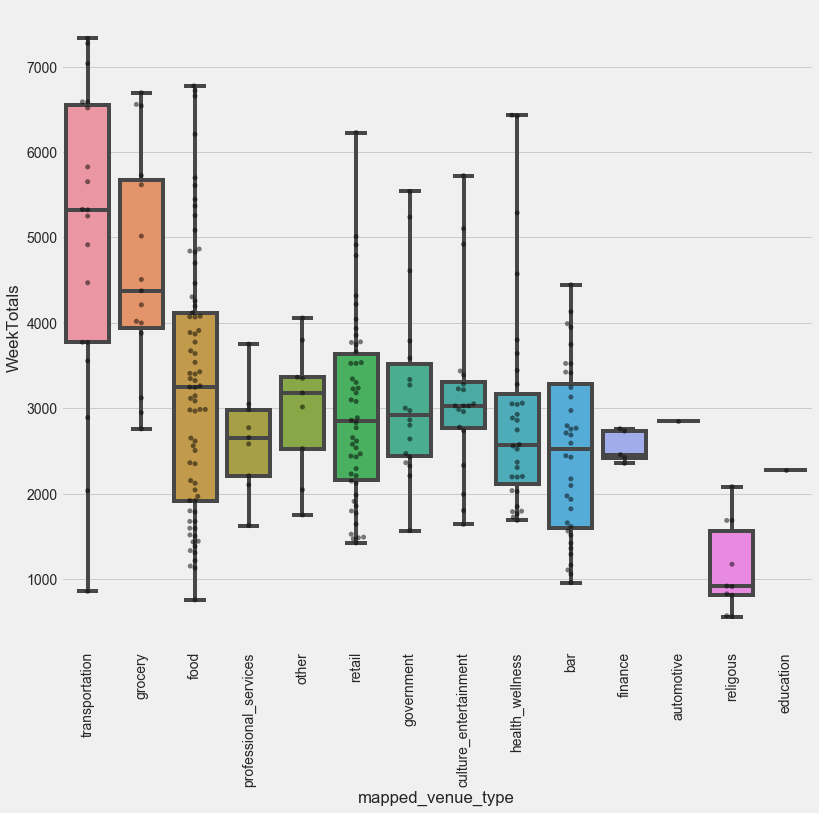

In [12]:
plt.figure(figsize=plot_size,facecolor='white')
#plt.style.use('seaborn-white')
plt.style.use('fivethirtyeight')

#sample data where we have count data
box_sample_data = df_processed[df_processed['WeekTotals']>0] #.sample(2000)

#define order of x axis
x_order = ["transportation", "grocery", "food",
         "professional_services","other","retail","government","culture_entertainment",
         "health_wellness","bar","finance",
         "automotive","religous","education"]

#define plot size
f, ax = plt.subplots(1, figsize=plot_size)

#plot boxplot
ax = sns.boxplot(x="mapped_venue_type", y="WeekTotals", data=box_sample_data, whis=np.inf, order=x_order)
#plot swarmplot
ax = sns.swarmplot(x="mapped_venue_type", y="WeekTotals", data=box_sample_data, color='black',alpha=0.5,order=x_order)

#rotate x axis labels 
plt.xticks(rotation=90)

#save image to file
plt.savefig("../data_archives/plot_exports/box_swarm/box_swarm1.jpg", dpi=300, edgecolor='w',
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None)

### plot map of store location

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


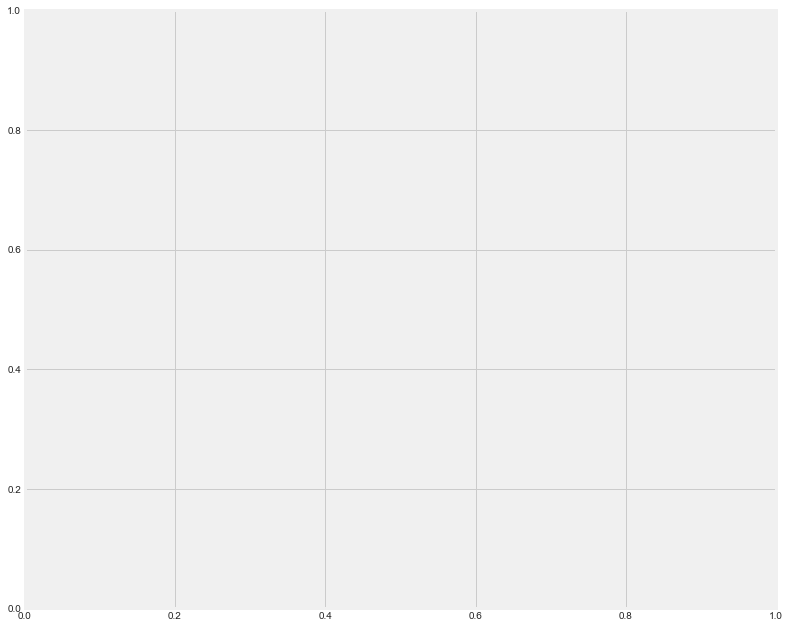

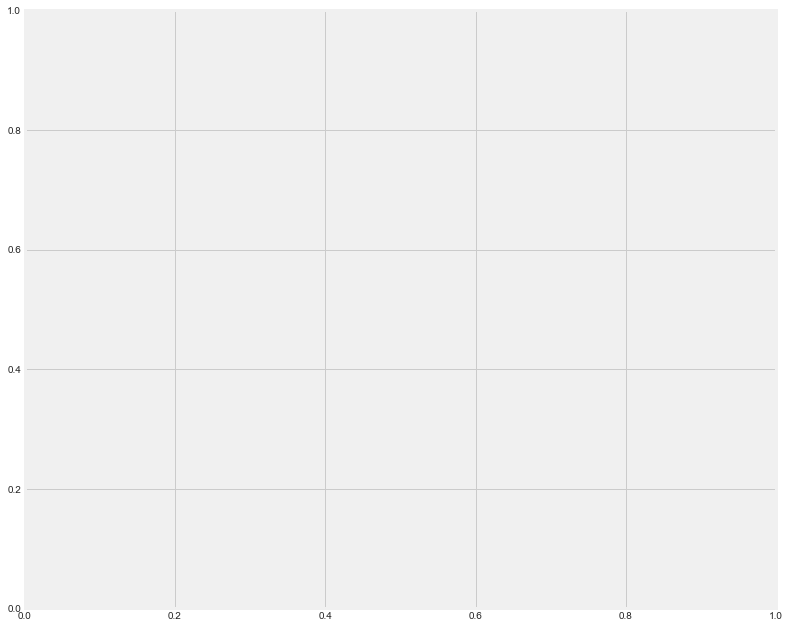

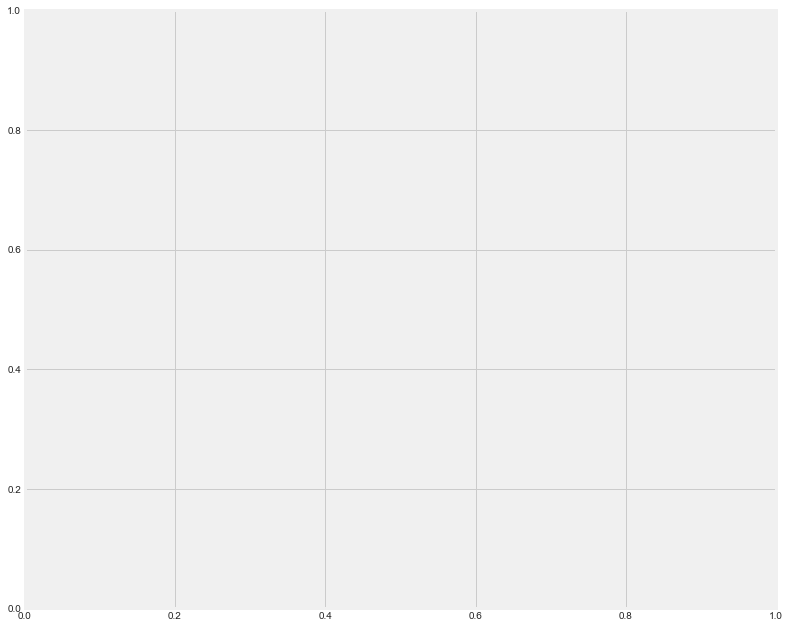

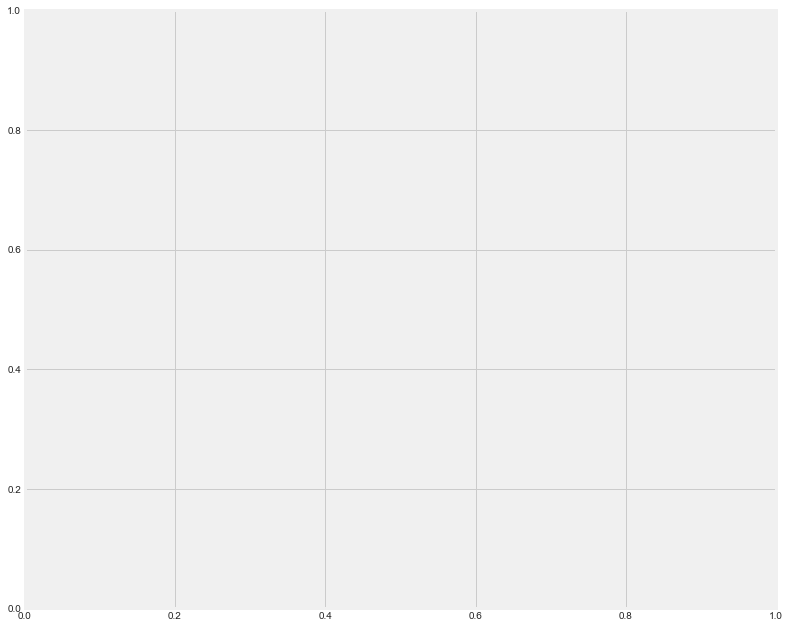

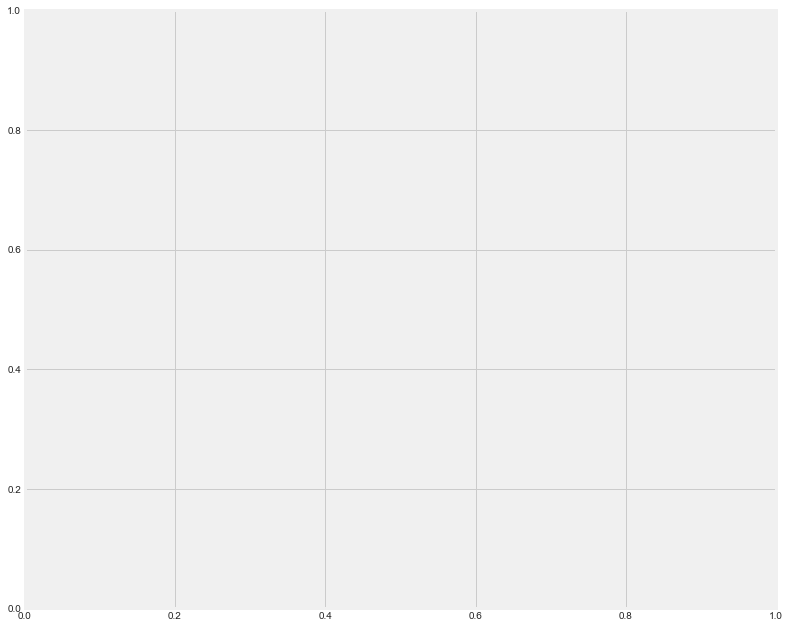

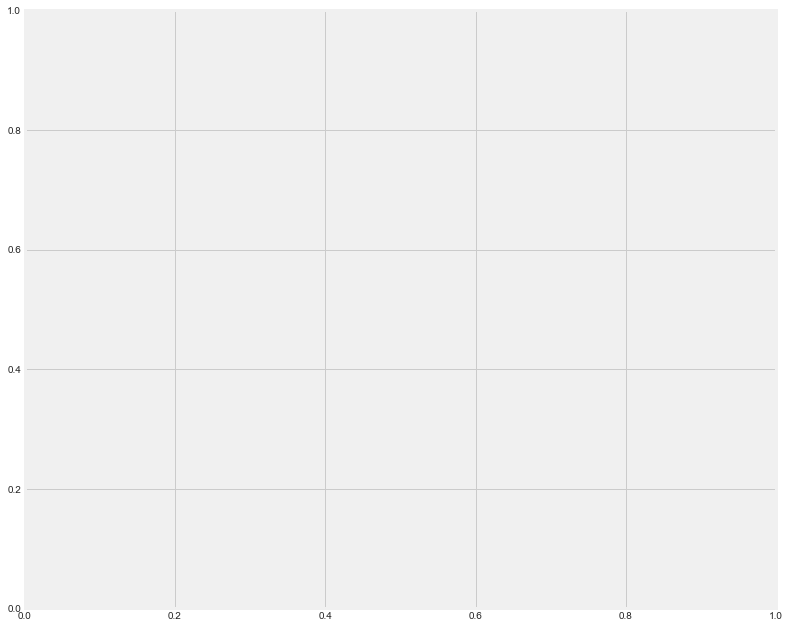

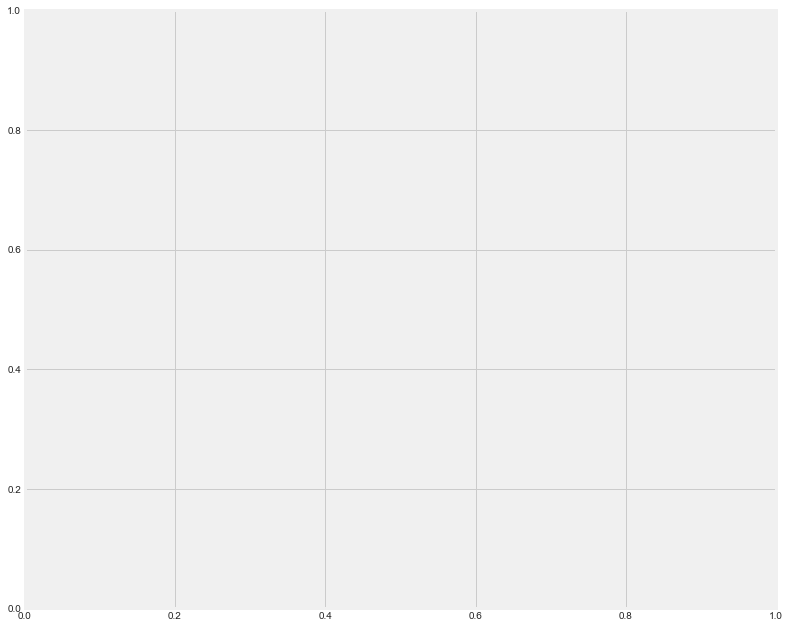

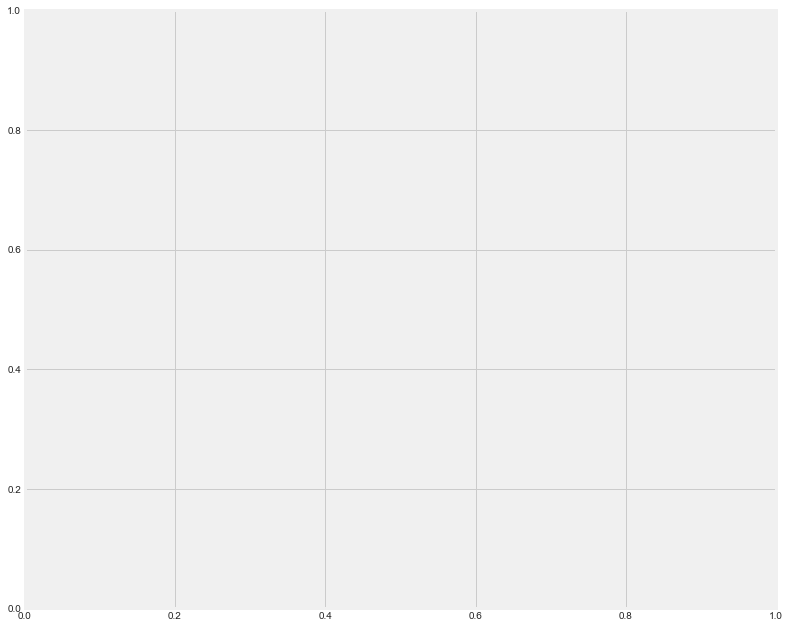

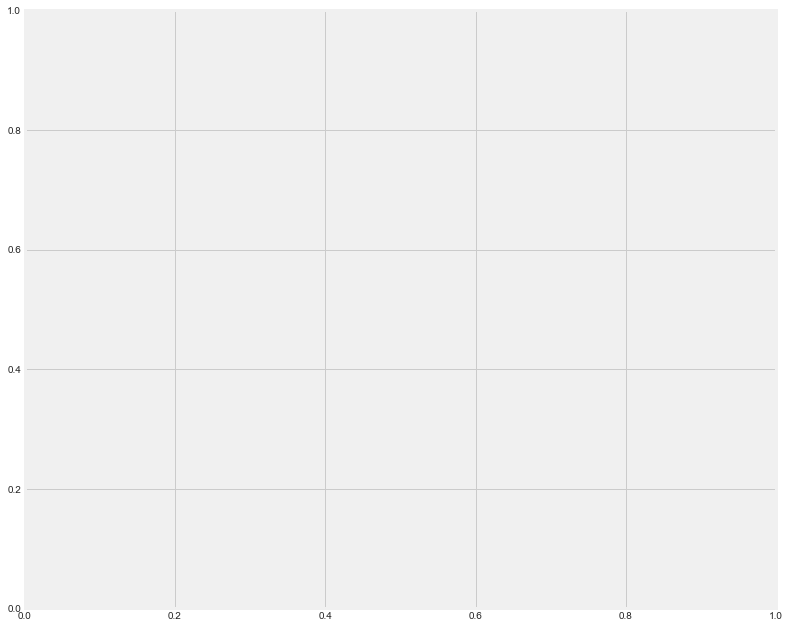

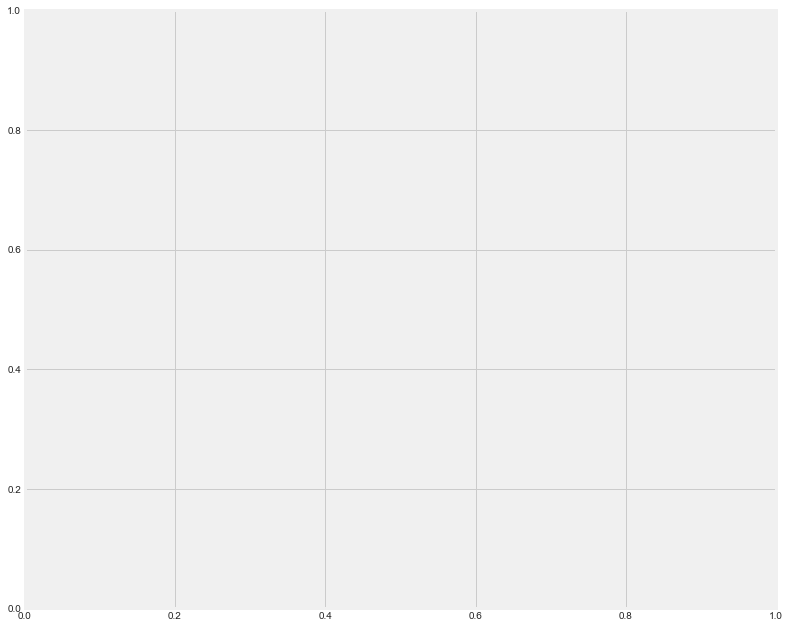

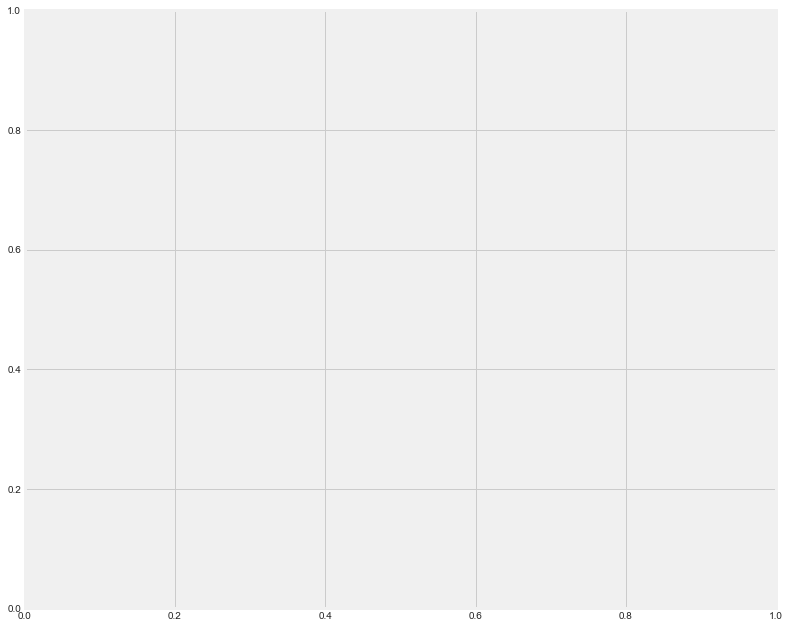

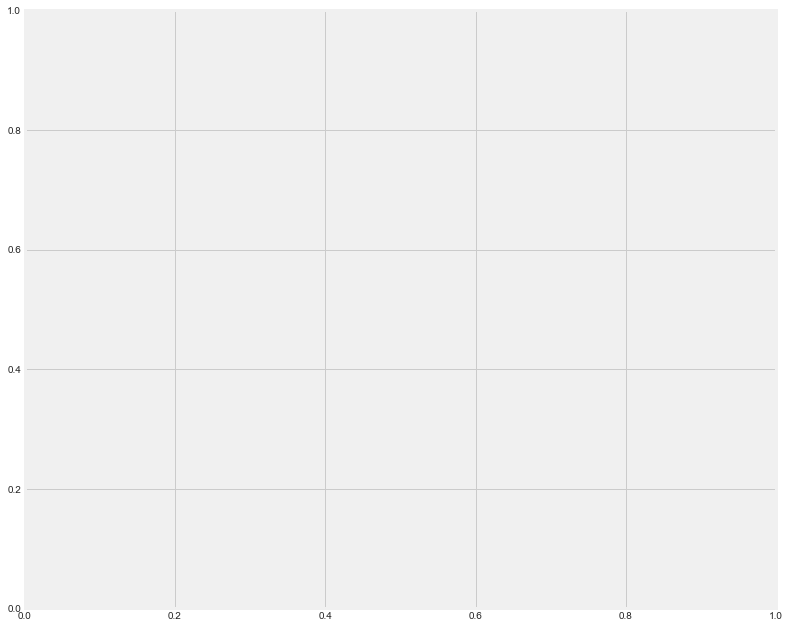

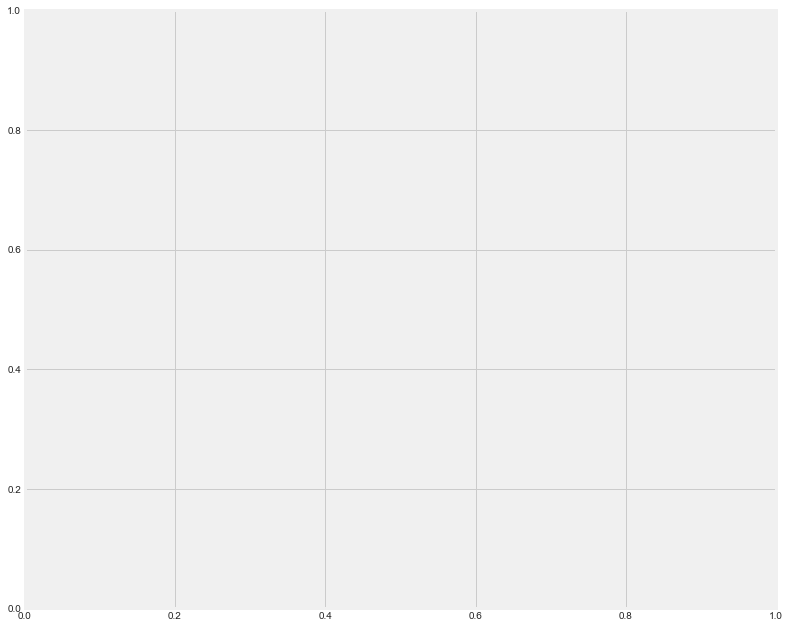

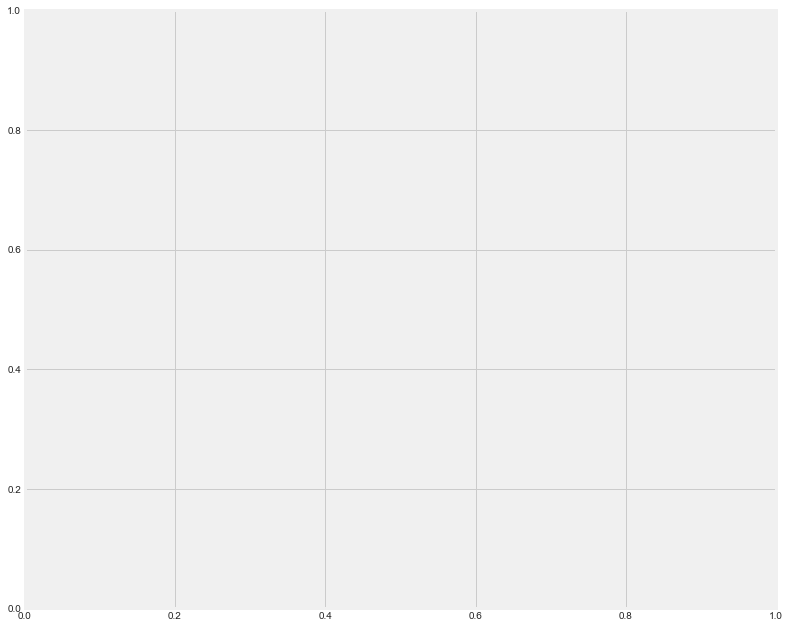

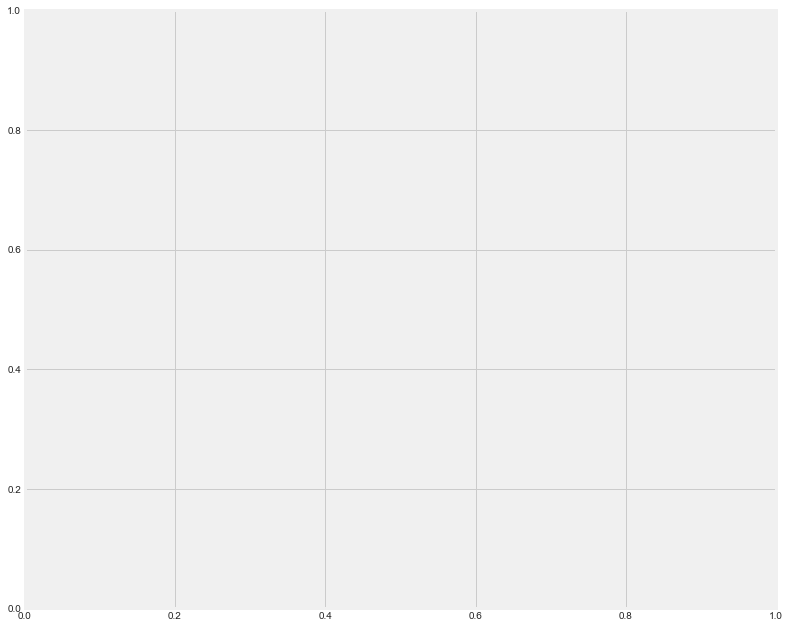

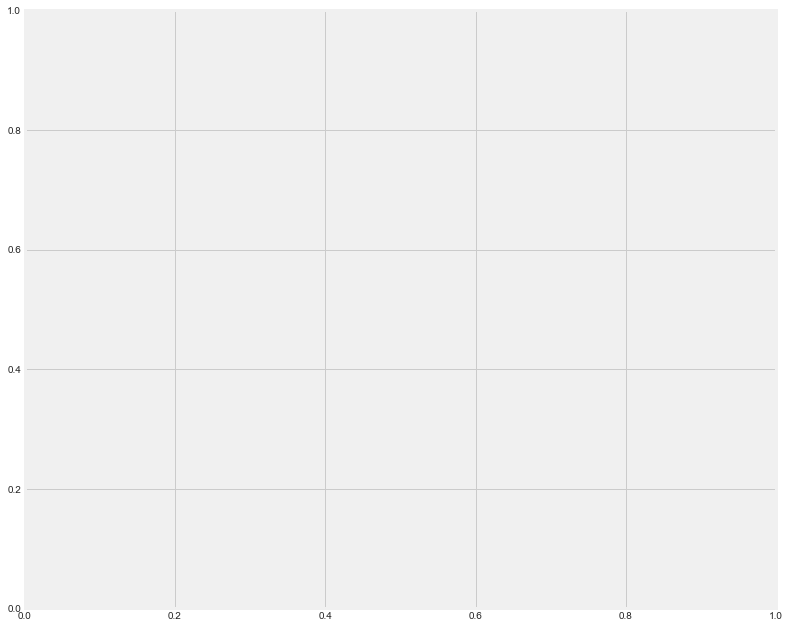

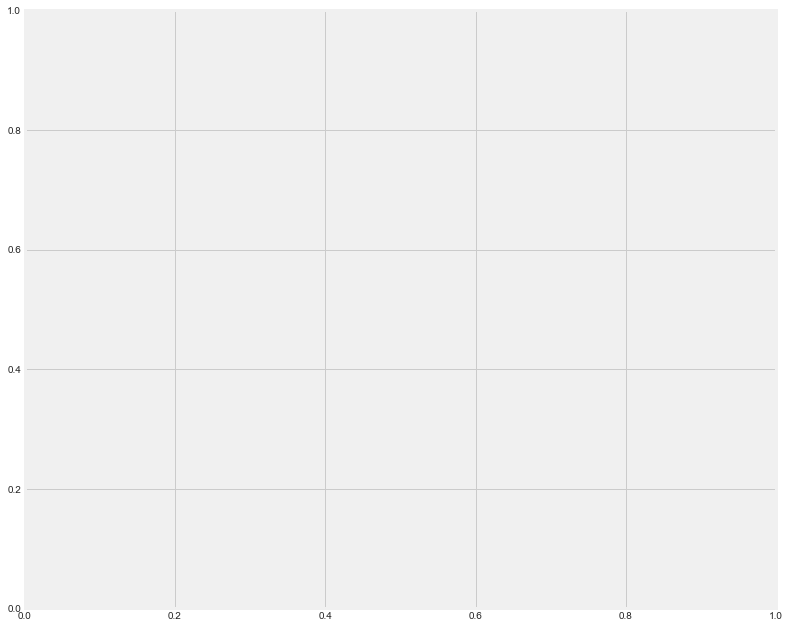

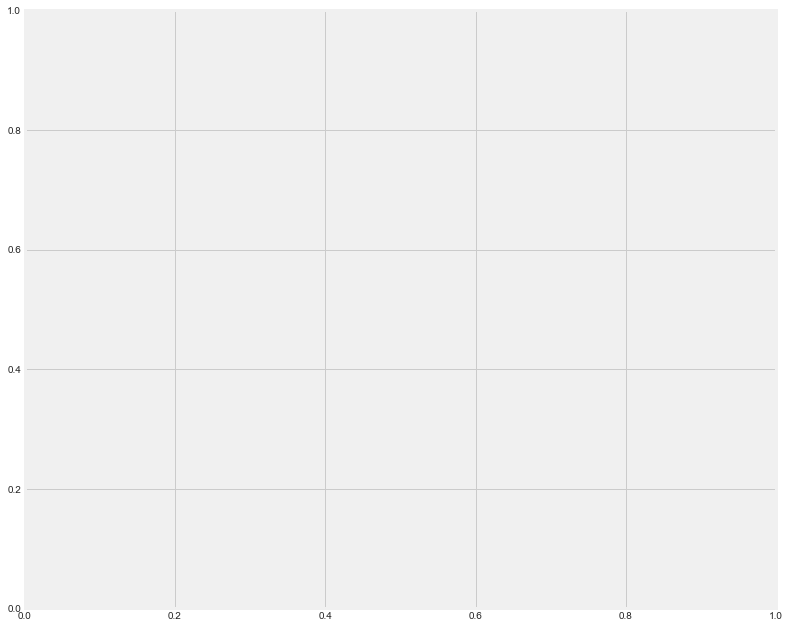

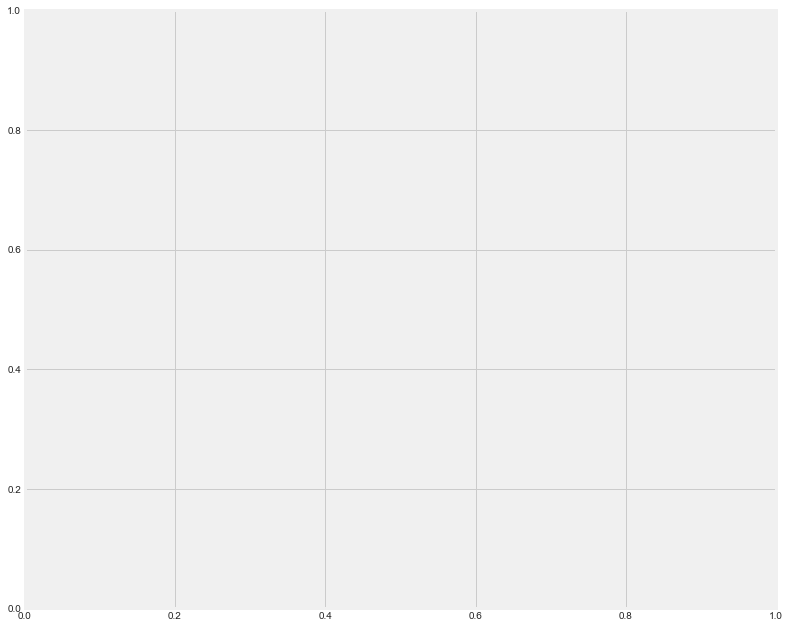

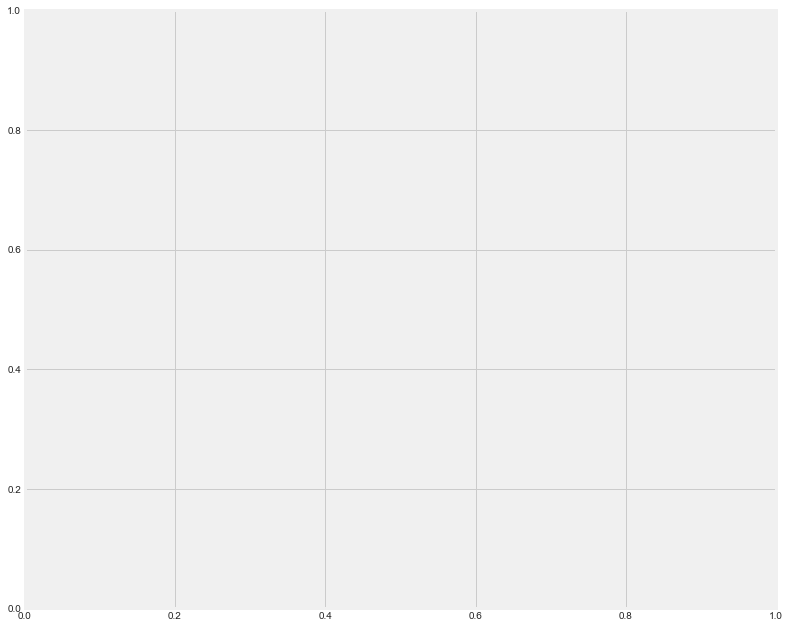

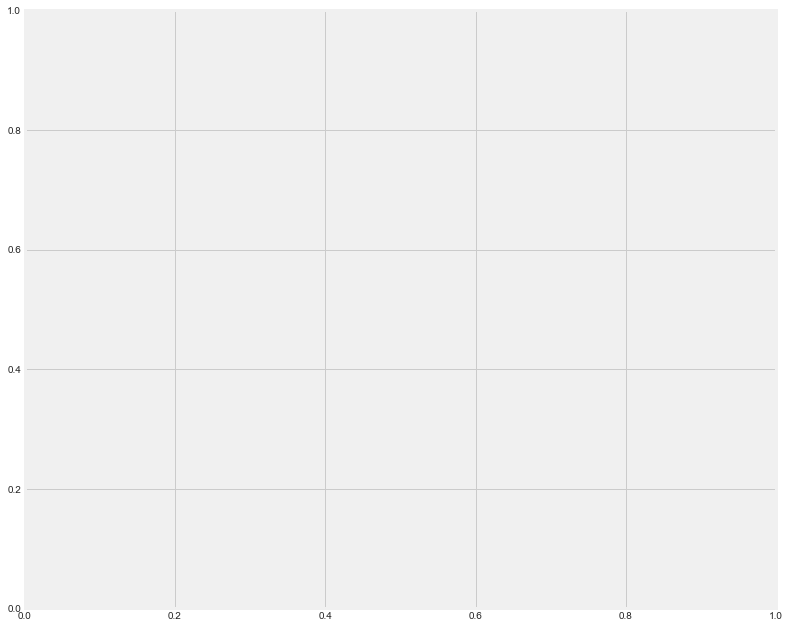

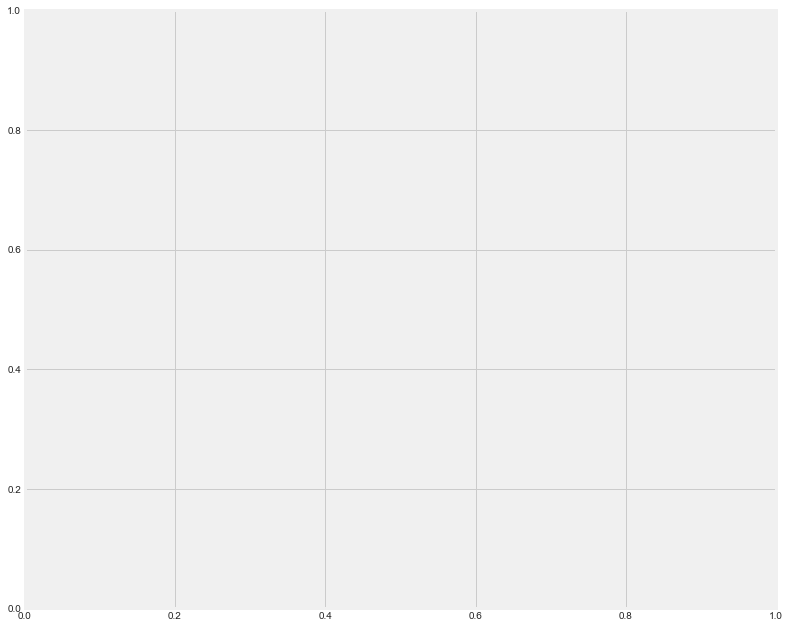

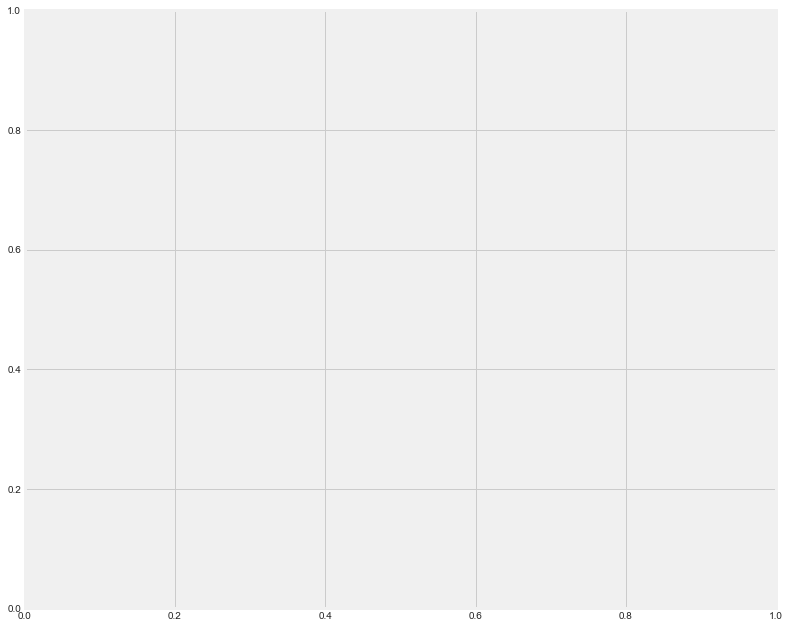

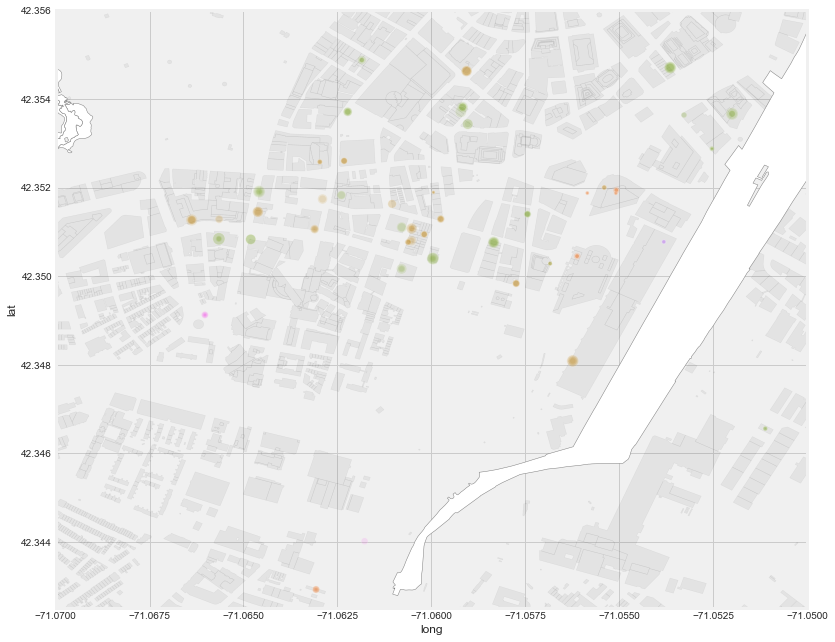

In [24]:
#define plot size
#plt.figure(figsize=plot_size,facecolor='white')
#plt.style.use('seaborn-white')
plt.style.use('fivethirtyeight')
%matplotlib inline

#configure shapefile projection
building_shapefile = building_shapefile.to_crs({'init': 'epsg:4326'}) 

#plot figure for each hour of the day
for i in range(24):
    
    #define plot size
    f, ax = plt.subplots(1, figsize=plot_size)
    
    #define plot ranges
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    #plot shapefile of boston buildings
    ax = building_shapefile.plot(ax=ax,alpha=.05,edgecolor='black',facecolor='#000000')
    
    #plot scatter of store locations
    ax = sns.scatterplot(x='long', y='lat', 
                         data=df_time_records_joined[df_time_records["hour"]==i],
                         s=1.5*df_time_records_joined[df_time_records["hour"]==i]["count"],
                         alpha=0.15,
                         hue='mapped_venue_type')
    
    #overlay shapefile of botston waterway
    ax = shapefile.plot(ax=ax,alpha=1.0,edgecolor='grey',facecolor='white')
    ax.legend_.remove()
    
    
    #save figure to file
    plt.savefig("../data_archives/plot_exports/scatter_map_color/hour_{}.jpg".format(i), dpi=300, facecolor='w', edgecolor='w',
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None)
    #plt.show()
    plt.clf
    plt.close
    if i < 23:
        plt.cla()

### activity heatmap - combined

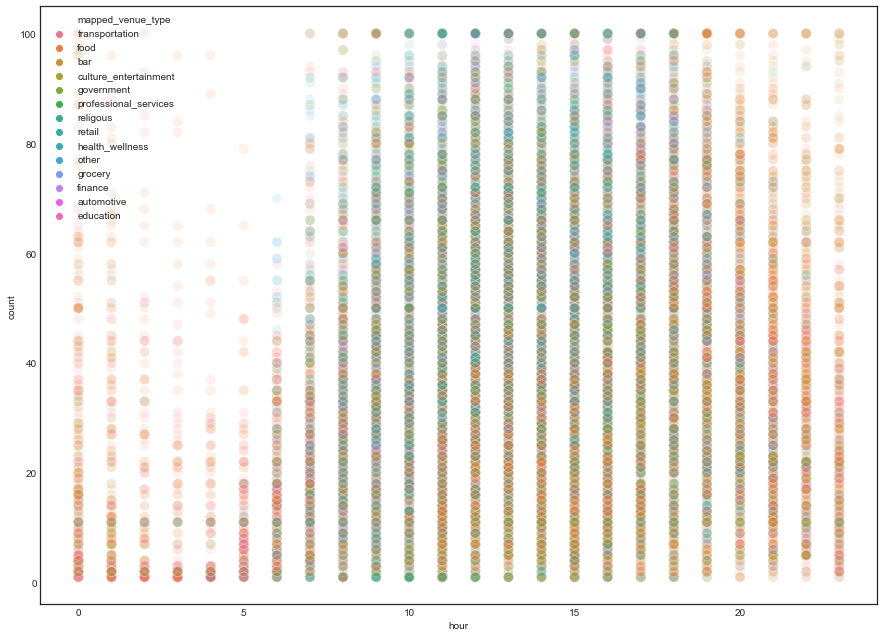

In [29]:
#define plot size
plt.figure(figsize=plot_size)

#plot figure
ax = sns.scatterplot(x='hour', y='count', 
                         data=df_time_records_joined[df_time_records_joined['count']>0],s=100,
                         alpha=0.1,
                         hue='mapped_venue_type')
plt.show()

### activity heatmap - by program

In [25]:
#group by time and venue type for averages of counts
grouped_averages = df_time_records_joined.groupby(['day_hour','mapped_venue_type'])['count'].mean()

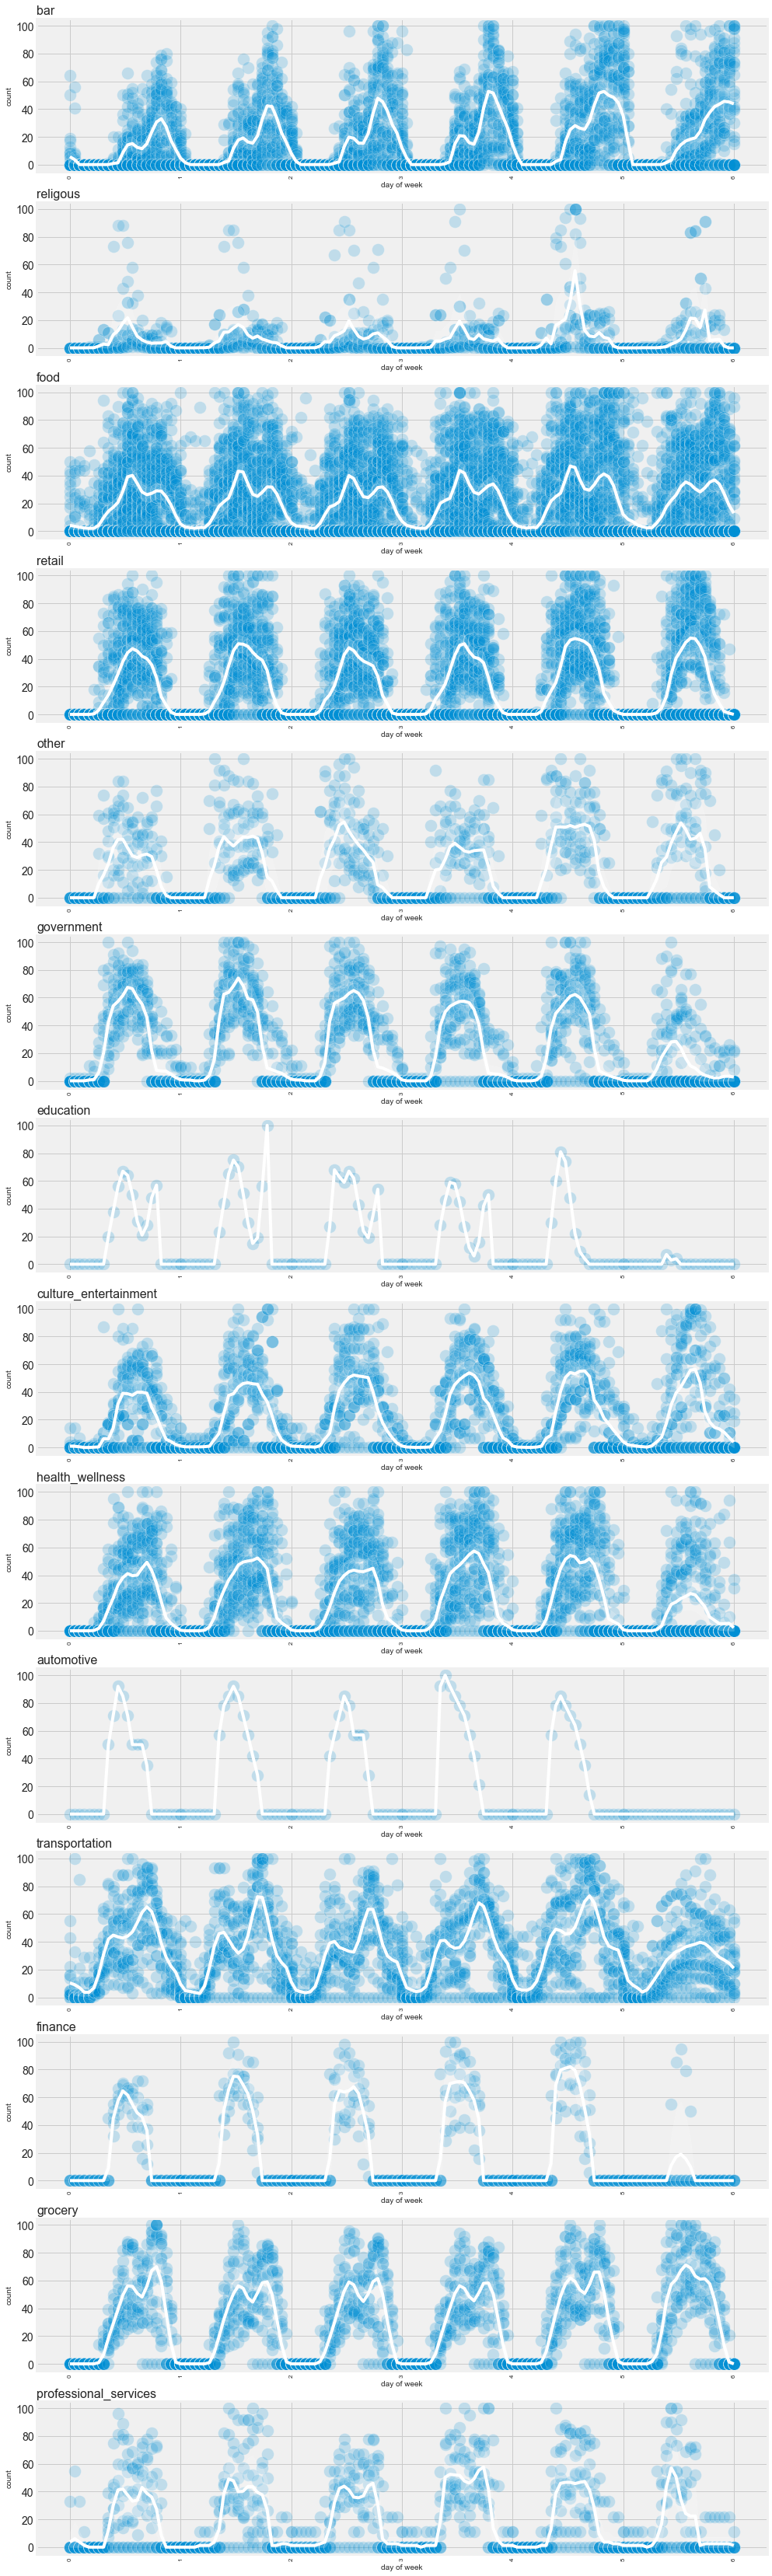

In [26]:
#define plot size
plt.figure(figsize=(15,60))
plt.style.use('fivethirtyeight')
time_data = df_time_records_joined #[df_time_records['count']>0]

plot_cols = 1
plot_rows = len(set(df_processed['mapped_venue_type']))
counter = 1
for v_type in set(set(df_processed['mapped_venue_type'])):

    plt.subplot(plot_rows,plot_cols,counter)
    ax = sns.scatterplot(x='day_hour', y='count', 
                         data=time_data[time_data['mapped_venue_type']==v_type],
                         s=250,
                         alpha=.2,
                         marker='o')
    ax = sns.lineplot(x='day_hour',y='count',data=time_data[time_data['mapped_venue_type']==v_type],color='white')
    
    plt.title(v_type,fontsize=16, loc='left')
    plt.xticks(rotation='vertical',size=8)
    plt.xlabel('day of week',fontsize=10)
    plt.ylabel('count',fontsize=10)
    
    try:
        ax.legend_.remove()
    except:
        pass
    counter += 1
plt.savefig("../data_archives/plot_exports/heat_plot/program_heat_plot.jpg".format(i), dpi=300,
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None)
plt.show()